In [1]:
#EDIT ME to change target subreddit...
target_subreddit = "anime" # scraped data includes: ['Naruto', 'BokuNoHeroAcademia', 'anime', 'manga', 'comicbooks',
                                                    # 'StarWars', 'startrek', 'LonghornNation', 'cfb', 'Genshin_Impact']
scrape_type = "submission"  # set to "submission" or "comment"

# Import

In [2]:
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [3]:
# Read in data
all_data = pd.read_csv(f'../data/{target_subreddit}_{scrape_type}s.csv')

In [4]:
all_data.head()

,Unnamed: 0,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,...,retrieved_utc,updated_utc,utc_datetime_str,post_hint,url_overridden_by_dest,preview,author_cakeday,edited_on,poll_data,tournament_data
0,0,anime,&amp;#x200B;\n\n[Original Image: https:\/\/as....,t2_f6yybj7y,0,There are 24 days left for the Re:zero panel a...,"[{'e': 'text', 't': 'Discussion'}]",r/anime,False,6.0,...,1677811538,1677811539,2023-03-03 02:45:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,anime,NaN,t2_gguj2,0,Average American Home Invasion (Gunsmith Cats),"[{'e': 'text', 't': 'Clip'}]",r/anime,False,6.0,...,1677811455,1677811455,2023-03-03 02:43:59,hosted:video,https://v.redd.it/0ctmpzpsrfla1,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN
2,2,anime,[removed],t2_qp6tl9uf,0,Animesurge is the best place to watch anime,"[{'e': 'text', 't': 'Discussion'}]",r/anime,False,6.0,...,1677811272,1677811272,2023-03-03 02:40:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,anime,Pictures:\nhttps://ibb.co/YbkKjPs\nhttps://ibb...,t2_cxyb82cp,0,"My First Ever Cosplay, 100% made by me! The ma...","[{'e': 'text', 't': 'Cosplay'}]",r/anime,False,6.0,...,1677810773,1677810774,2023-03-03 02:32:37,self,NaN,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN
4,4,anime,Making yet another [post](https://www.reddit.c...,t2_1gyk011d,0,"Why ""Attack on Titan the Final Arc Part 1"" isn...","[{'e': 'text', 't': 'Discussion'}]",r/anime,False,6.0,...,1677810601,1677810601,2023-03-03 02:29:42,self,NaN,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN


# Choosing a sub-set of columns worth keeping for (possible) analysis

In [5]:
all_data.columns

Index(['Unnamed: 0', 'subreddit', 'selftext', 'author_fullname', 'gilded',
       'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden',
       'pwls', 'link_flair_css_class', 'thumbnail_height', 'top_awarded_type',
       'hide_score', 'media_metadata', 'quarantine', 'link_flair_text_color',
       'upvote_ratio', 'author_flair_background_color', 'subreddit_type',
       'total_awards_received', 'media_embed', 'thumbnail_width',
       'author_flair_template_id', 'is_original_content', 'secure_media',
       'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed',
       'link_flair_text', 'score', 'is_created_from_ads_ui', 'author_premium',
       'thumbnail', 'edited', 'author_flair_css_class',
       'author_flair_richtext', 'gildings', 'content_categories', 'is_self',
       'link_flair_type', 'wls', 'removed_by_category', 'author_flair_type',
       'domain', 'allow_live_comments', 'suggested_sort', 'view_count',
       'archived', 'no_follow', 'is_cro

In [6]:
# columns investigated one-by-one, systematically... no real valuable data found other than columns used below

# all_data['gildings'].value_counts()
# all_data[all_data['gildings']!="{}"]

In [7]:
df = all_data[['subreddit','selftext', 'author_fullname', 'title', 'upvote_ratio', 
              'is_reddit_media_domain', 'domain', 'over_18', 'spoiler', 'id', 
              'author', 'num_comments', 'created_utc', 'is_video'
             ]].copy()   #used .copy() to reduce number of warnings later

df.head()

,subreddit,selftext,author_fullname,title,upvote_ratio,is_reddit_media_domain,domain,over_18,spoiler,id,author,num_comments,created_utc,is_video
0,anime,&amp;#x200B;\n\n[Original Image: https:\/\/as....,t2_f6yybj7y,There are 24 days left for the Re:zero panel a...,1.0,False,self.anime,False,False,11gp0gm,Emotional-Plan-5829,0,1677811524,False
1,anime,NaN,t2_gguj2,Average American Home Invasion (Gunsmith Cats),1.0,False,/r/anime/comments/11gozcr/average_american_hom...,False,False,11gozcr,KerberosPanzerCop,0,1677811439,True
2,anime,[removed],t2_qp6tl9uf,Animesurge is the best place to watch anime,1.0,False,self.anime,False,False,11gowy9,zeak_the_geek,1,1677811255,False
3,anime,Pictures:\nhttps://ibb.co/YbkKjPs\nhttps://ibb...,t2_cxyb82cp,"My First Ever Cosplay, 100% made by me! The ma...",1.0,False,self.anime,False,False,11goqg9,Not_So_Normal711,0,1677810757,False
4,anime,Making yet another [post](https://www.reddit.c...,t2_1gyk011d,"Why ""Attack on Titan the Final Arc Part 1"" isn...",1.0,False,self.anime,False,False,11gonxd,Mazen141,0,1677810582,False


# Create new columns that might be useful

In [8]:
# Convert UTC times to human-readable

df['created_datetime'] = pd.to_datetime(df['created_utc'], unit='s')

#Reference: https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [9]:
# Make a combined column of seltext + title, for combined processing

cond1 = df['selftext'].notna()
cond2 = df['selftext'] != '[removed]'

df['combined_text'] = np.where((cond1 & cond2),
                                df['title'] + " " + df['selftext'],
                                df['title'])      #if selftext is blank or [removed], just use only the title

In [10]:
df["combined_text_length"] = df['combined_text'].str.len()

In [11]:
df["combined_wordcount"] = df['combined_text'].str.split(" ").str.len()

# Text normalization (lemmatizing, tokenizing, stop words)

In [12]:
# Lemmatizing 
# Reference: Lesson 504

wn = WordNetLemmatizer()

def custom_lemmatize(word, tag):
    mapper = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    pos = mapper.get(tag[0])
    
    return wn.lemmatize(word, pos) if pos else word

In [13]:
df['lemmatized_text'] = ""

for i in range(df.shape[0]):
    df.loc[i,'lemmatized_text'] = \
        " ".join([custom_lemmatize(word, tag) for word, tag in nltk.pos_tag( df['combined_text'][i].split(" "))])

In [14]:
# Tokenizing & stopword removal AFTER lemmatizing
# Reference: General Assembly, DSI Lesson 504 - NLP-ii

tokenizer = RegexpTokenizer('\w+')

my_added_stopwords = ["amp", "https", "redd", "com", "link", "www", "net", "imgur"]

df['tokenized_text'] = ""

for i in range(df.shape[0]):
    my_text_tokens = tokenizer.tokenize(df['lemmatized_text'][i].lower())
    my_text_tokens_ns = [token for token in my_text_tokens if (token not in stopwords.words("english") and token not in my_added_stopwords)]
    recombined_text = " ".join(my_text_tokens_ns)
    df.loc[i,'tokenized_text'] = recombined_text


In [15]:
df.head()

,subreddit,selftext,author_fullname,title,upvote_ratio,is_reddit_media_domain,domain,over_18,spoiler,id,author,num_comments,created_utc,is_video,created_datetime,combined_text,combined_text_length,combined_wordcount,lemmatized_text,tokenized_text
0,anime,&amp;#x200B;\n\n[Original Image: https:\/\/as....,t2_f6yybj7y,There are 24 days left for the Re:zero panel a...,1.0,False,self.anime,False,False,11gp0gm,Emotional-Plan-5829,0,1677811524,False,2023-03-03 02:45:24,There are 24 days left for the Re:zero panel a...,484,20,There be 24 day leave for the Re:zero panel at...,24 day leave zero panel animejapan 2023 x200b ...
1,anime,NaN,t2_gguj2,Average American Home Invasion (Gunsmith Cats),1.0,False,/r/anime/comments/11gozcr/average_american_hom...,False,False,11gozcr,KerberosPanzerCop,0,1677811439,True,2023-03-03 02:43:59,Average American Home Invasion (Gunsmith Cats),46,6,Average American Home Invasion (Gunsmith Cats),average american home invasion gunsmith cats
2,anime,[removed],t2_qp6tl9uf,Animesurge is the best place to watch anime,1.0,False,self.anime,False,False,11gowy9,zeak_the_geek,1,1677811255,False,2023-03-03 02:40:55,Animesurge is the best place to watch anime,43,8,Animesurge be the best place to watch anime,animesurge best place watch anime
3,anime,Pictures:\nhttps://ibb.co/YbkKjPs\nhttps://ibb...,t2_cxyb82cp,"My First Ever Cosplay, 100% made by me! The ma...",1.0,False,self.anime,False,False,11goqg9,Not_So_Normal711,0,1677810757,False,2023-03-03 02:32:37,"My First Ever Cosplay, 100% made by me! The ma...",294,42,"My First Ever Cosplay, 100% make by me! The ma...",first ever cosplay 100 make mask much fun make...
4,anime,Making yet another [post](https://www.reddit.c...,t2_1gyk011d,"Why ""Attack on Titan the Final Arc Part 1"" isn...",1.0,False,self.anime,False,False,11gonxd,Mazen141,0,1677810582,False,2023-03-03 02:29:42,"Why ""Attack on Titan the Final Arc Part 1"" isn...",7444,1133,"Why ""Attack on Titan the Final Arc Part 1"" isn...",attack titan final arc part 1 final season mak...


In [16]:
df.shape

(4734, 20)

In [17]:
cvec1 = CountVectorizer(stop_words="english")
cvec1.fit(df['tokenized_text'])
X_train_cvectorized = cvec1.transform(df['tokenized_text'])

X_train_df = pd.DataFrame(X_train_cvectorized.todense(), columns = cvec1.get_feature_names_out())
top15 = X_train_df.sum().sort_values(ascending=False).head(15)
top15

anime          5742
episode        2130
youpoll        1783
like           1362
watch          1356
2023            764
zero            758
know            726
familiar        688
character       676
think           600
myanimelist     581
good            543
time            530
season          527
dtype: int64

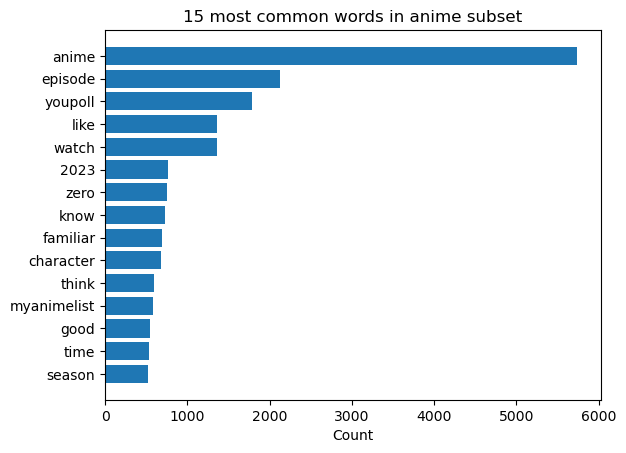

In [18]:
plt.barh(top15.index[::-1], top15[::-1],label=top15) ;
plt.title(f'15 most common words in {target_subreddit} subset')
plt.xlabel('Count');

# Write output to csv

In [19]:
df.to_csv(f'../data/{target_subreddit}_{scrape_type}s_preprocessed.csv', index=False)